In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import int64
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from math import sqrt


import xgboost as xgb


In [2]:
VCexists = pd.read_csv('VCexists_Cleaned.csv', encoding='latin-1')

In [3]:
VCexists.isnull().sum()

Company PBID                                           0
Exit Type                                              0
Industry Sector                                        0
Industry Group                                         0
Industry Code                                          0
Verticals                                              0
Exit Date                                              0
Exit Size (millions)                                   0
Pre Value (millions)                                   0
Post Value (millions)                                  0
Last VC Deal Type                                      0
Total VC Capital Raised ($M)***                        0
Total Preferred Capital Raised ($M)*                   0
% Preferred Capital Raised*                            0
Total Preferred Capital Raised ($M) - Combination**    0
% Preferred Capital Raised - Combination**             0
MOIC                                                   0
State                          

In [4]:
VCexists.describe()

,Exit Size (millions),Pre Value (millions),Post Value (millions),Total VC Capital Raised ($M)***,Total Preferred Capital Raised ($M)*,% Preferred Capital Raised*,Total Preferred Capital Raised ($M) - Combination**,% Preferred Capital Raised - Combination**,MOIC
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,934.285842,2753.209535,979.848739,55.585817,70.004643,0.867544,72.859186,0.871300,10.880382
std,2295.280768,2128.701623,2459.211399,139.697932,125.934277,0.208667,124.663417,0.209410,8.017902
min,0.149924,16.366500,0.149924,0.010000,0.150000,0.178828,0.150000,0.178828,0.149798
25%,249.828500,2194.298450,252.331007,4.000000,21.887504,0.848278,21.537510,0.840372,8.109260
50%,542.878000,2699.340880,654.387390,17.939700,51.105425,0.879790,60.022480,0.887074,9.751220
75%,968.406990,2964.896240,853.321970,51.272455,64.870480,0.967216,72.713440,0.988069,11.860130
max,29843.400000,29843.400000,33203.400000,1401.760000,1401.755425,3.402224,1401.755425,3.402224,65.336300


In [5]:
VCexists.describe(include=[object])

,Company PBID,Exit Type,Industry Sector,Industry Group,Industry Code,Verticals,Exit Date,Last VC Deal Type,State,City,Country
count,348,348,348,348,348,348,348,348,348,348,348
unique,348,6,5,11,38,105,311,24,32,155,28
top,118165-51,Merger/Acquisition,Information Technology,Software,Business/Productivity Software,"SaaS, TMT, CloudTech & DevOps",8/17/2015,Early Stage VC,California,San Francisco,United States
freq,1,254,328,293,83,81,3,84,209,54,226


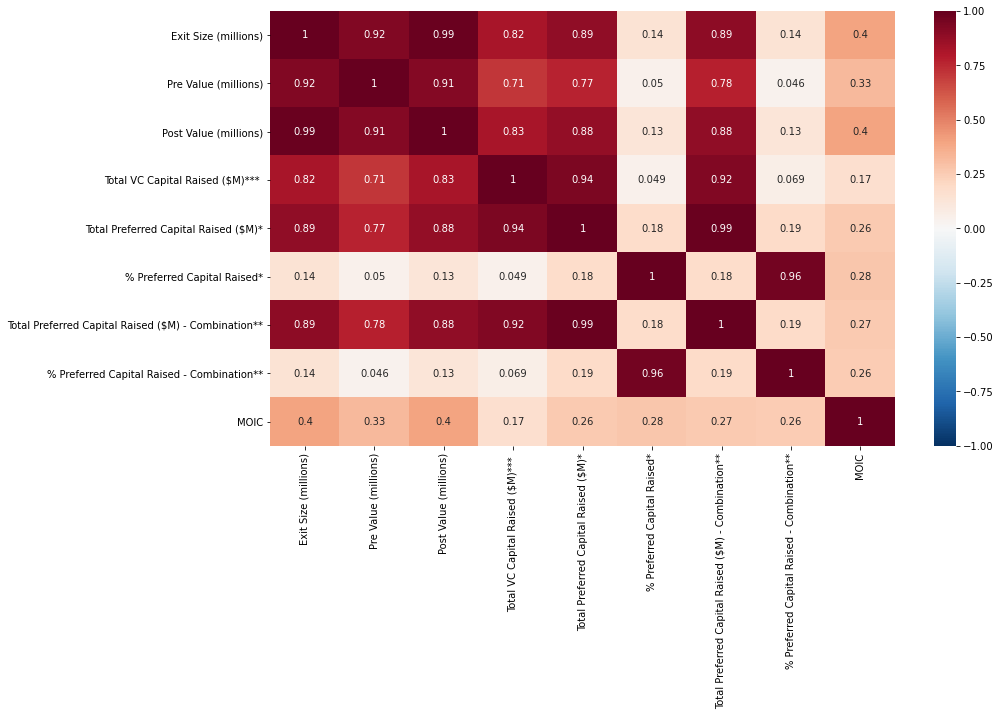

In [6]:
correlation = VCexists.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

# Removing multicolinear feature variable

1. Exit Size, Pre-value and Post value are extremly correlated to each other(coeff more than 0.90)

   **Removing Exit Size, Pre-value and keeping Post value**
   

2. Total VC capital Raised and Total Preferred capital Riased extremely correlated with each other(coeff 0.94)

    **Removing Total Preferred capital Riased and keeping Total VC capital Raised**
    
    
3. Percentage Prefered Capital Raised and Percentage Prefered Capital Raised - Combination extremly correlated (coeff 0.96)
 
   **Removing "Percentage Prefered Capital Raised - Combination" and Keeping "Percentage Prefered Capital Raised"**

In [7]:
VCexists = VCexists.drop(['Exit Size (millions)','Pre Value (millions)', 
                          'Total VC Capital Raised ($M)*** ', 'Total Preferred Capital Raised ($M) - Combination**',
                          '% Preferred Capital Raised - Combination**'],axis=1)

## Encoding

In [8]:
encode=LabelEncoder()
catcol = ['Company PBID','Exit Type','Industry Sector', 'Industry Group', 'Industry Code',
          'Exit Date', 'Last VC Deal Type', 'State', 'City', 'Country']  #

In [9]:
VCexists[catcol] = VCexists[catcol].apply(encode.fit_transform)

In [10]:
VCexists = VCexists.drop(['Company PBID'],axis=1)

In [11]:
dumm = VCexists['Verticals'].str.get_dummies(sep=',').add_prefix('Verticals_')

In [12]:
VCexists = pd.concat([VCexists, dumm], axis=1)

In [13]:
VCexists = VCexists.drop(columns='Verticals')


## Test-Model 1  
### Target Variable: MOIC

In [14]:
X = VCexists.drop(columns='MOIC')
y = VCexists.MOIC

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 21)

In [16]:
y_train = y_train.apply(np.log)
y_test = y_test.apply(np.log)

In [17]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                max_depth = 25, alpha = 4, reg_lambda= 3, n_estimators = 200)
xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=25,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=4, reg_lambda=3, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
y_pred = xg_reg.predict(X_train)
RMSE = sqrt(mean_squared_error(y_train , y_pred))
R2 = r2_score(y_train , y_pred)
print("RMSE of Model is    : {:.2f}"
          .format(RMSE))
print("R-square of Model is : {:.4f}"
      . format(R2))

RMSE of Model is    : 0.26
R-square of Model is : 0.8515


In [19]:
y_pred = xg_reg.predict(X_test)
RMSE = sqrt(mean_squared_error(y_test , y_pred))
R2 = r2_score(y_test , y_pred)
print("RMSE of Model is    : {:.2f}"
          .format(RMSE))
print("R-square of Model is : {:.4f}"
      . format(R2))

RMSE of Model is    : 0.74
R-square of Model is : 0.2755


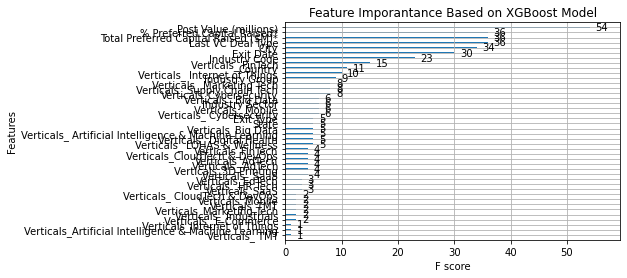

In [20]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [8, 8]
plt.title("Feature Imporantance Based on XGBoost Model")
plt.show()

## Test - Model 2
### Target Variable: Post Value


In [21]:
X = VCexists.drop(columns='Post Value (millions)')

y = VCexists['Post Value (millions)']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 21)

In [23]:
y_train = y_train.apply(np.log)
y_test = y_test.apply(np.log)

In [24]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                max_depth = 5, alpha = 4, reg_lambda= 3, n_estimators = 20)
xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=4, reg_lambda=3, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
y_pred = xg_reg.predict(X_train)
RMSE = sqrt(mean_squared_error(y_train , y_pred))
R2 = r2_score(y_train , y_pred)
print("RMSE of Model is    : {:.2f}"
          .format(RMSE))
print("R-square of Model is : {:.4f}"
      . format(R2))

RMSE of Model is    : 0.50
R-square of Model is : 0.9022


In [26]:
y_pred = xg_reg.predict(X_test)
RMSE = sqrt(mean_squared_error(y_test , y_pred))
R2 = r2_score(y_test , y_pred)
print("RMSE of Model is    : {:.2f}"
          .format(RMSE))
print("R-square of Model is : {:.4f}"
      . format(R2))

RMSE of Model is    : 1.25
R-square of Model is : 0.5466


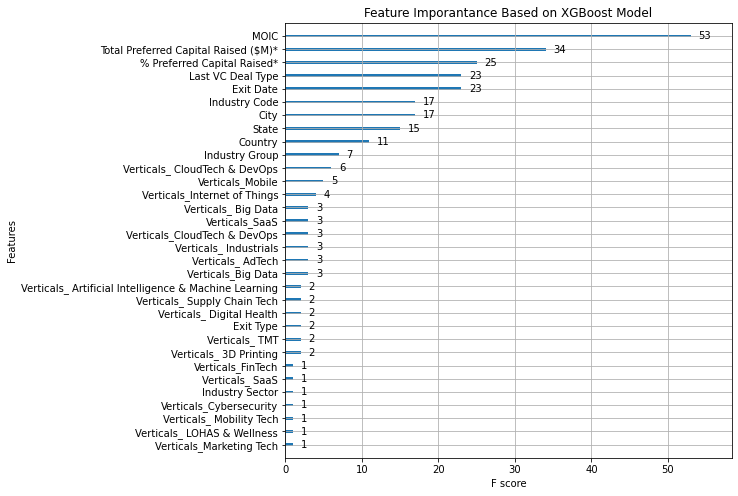

In [27]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [32, 8]
plt.title("Feature Imporantance Based on XGBoost Model")
plt.show()

## Test - Model 3
### Target Variable: Total Preferred Capital Raised

In [28]:
X = VCexists.drop(columns='Total Preferred Capital Raised ($M)*')

y = VCexists['Total Preferred Capital Raised ($M)*']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 21)

In [30]:
y_train = y_train.apply(np.log)
y_test = y_test.apply(np.log)

In [31]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                max_depth = 5, alpha = 4, reg_lambda= 3, n_estimators = 20)
xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=4, reg_lambda=3, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
y_pred = xg_reg.predict(X_train)
RMSE = sqrt(mean_squared_error(y_train , y_pred))
R2 = r2_score(y_train , y_pred)
print("RMSE of Model is    : {:.2f}"
          .format(RMSE))
print("R-square of Model is : {:.4f}"
      . format(R2))

RMSE of Model is    : 0.43
R-square of Model is : 0.9065


In [33]:
y_pred = xg_reg.predict(X_test)
RMSE = sqrt(mean_squared_error(y_test , y_pred))
R2 = r2_score(y_test , y_pred)
print("RMSE of Model is    : {:.2f}"
          .format(RMSE))
print("R-square of Model is : {:.4f}"
      . format(R2))

RMSE of Model is    : 0.93
R-square of Model is : 0.5688


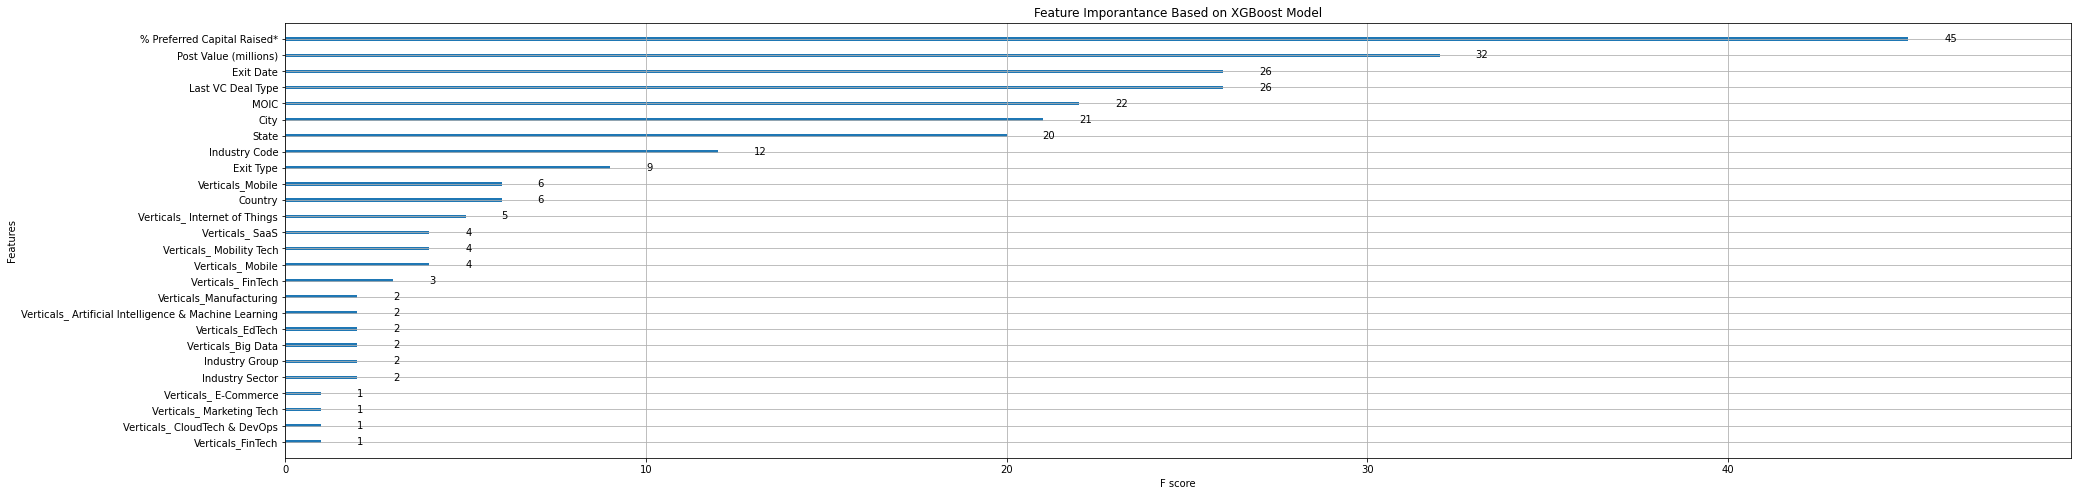

In [34]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [12, 8]
plt.title("Feature Imporantance Based on XGBoost Model")
plt.show()